In [ ]:
!git clone https://github.com/rslim087a/track
#the above repository consists of various images captures during the training 
#period of the self driving car by making use of 3 cameras present on the windsheild of the car(on left, right and center)
#the data captured is the 3 images, steer angle, thrust and brake information for the car

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 34.08 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [ ]:
!ls track
#this command is used to list the components present in the above repository


driving_log.csv  IMG


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D,Dropout,Dense,Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath
#ntpath is a library that would be used to limit the path of our images to only the leaf

Using TensorFlow backend.


In [ ]:
data_dir='track'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(data_dir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [ ]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail

data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


<BarContainer object of 25 artists>

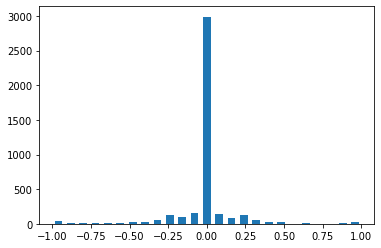

In [ ]:
#lets visualize the distribution of steering angles
#here, we are have chosen number of bins to be equal to 25 since we want our steering data to be centeres around 0
#0 implies driving straight
num_bins=25
hist,bins=np.histogram(data['steering'],num_bins)
print(bins)
#since data here is not centered around 0, we perform the element wise additon with the shifted array and divide by 2 since each value would double up on addition
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
#now it is evident that the most commmon steering angle is 0 radians


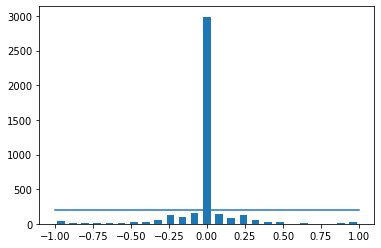

In [ ]:
#we can observe that 0 degree occurs alot more than other angles hence this may cause bias during testing
#therefore we would set some maximum threshold for samples
samples_per_bin=200
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total_data: 4053
removed: 2790
remaining: 1263


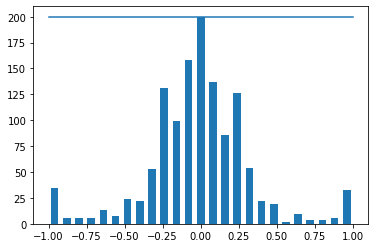

In [ ]:
# lets cut off the excess data
print('total_data:', len(data))
remove_list=[]
for j in range(num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_=shuffle(list_)
  list_=list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining:', len(data))

hist,_=np.histogram(data['steering'],num_bins)
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))





In [ ]:
def load_img_steering(datadir,df):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    #this would select a particular row of our dataset
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(data_dir,center.strip()))
    steering.append(float(indexed_data[3]))
    #indexed_data[3] contains steering angles
  image_paths=np.asarray(image_path)
  steering=np.asarray(steering)
  return image_path,steering

image_paths,steerings=load_img_steering(data_dir+'/IMG',data)
#now we have our dataset for images captured from the center camera and their corresponding steering angle

In [ ]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,random_state=6)
print('Training Samples= {} \nValidation Samples={}'.format(len(X_train),len(X_valid)))

Training Samples= 1010 
Validation Samples=253


Text(0.5, 1.0, 'Validation set')

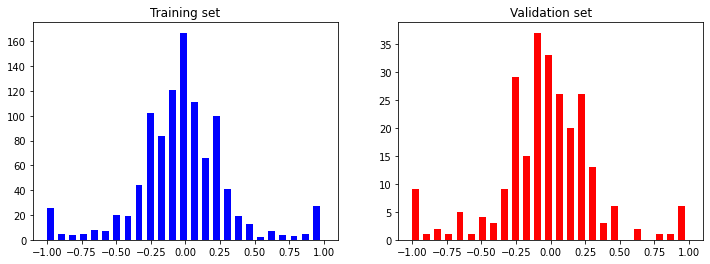

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid,bins=num_bins,width=0.05,color='red')
axes[1].set_title('Validation set')

In [ ]:
#we can observe a uniform distribution among training and test sets